In [14]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import pyvista as pv
from desmin_reconstruction.voronoi import random_uniform_like, VoronoiAnalysis
from tqdm import tqdm


plt.rc("font", size=12)
plt.rc("grid", linestyle="--", color="lightgray")
plt.rc("axes.spines", right=False, top=False)
pv.set_jupyter_backend("static")

datadir = Path("../data/")

In [2]:
filepath = datadir / "STORM/desmin_actin_2.5um.csv"
df = pl.read_csv(filepath)
df = df.with_columns(*[pl.col(i) / 1000 for i in ("x", "y", "z")])
df = df.with_columns(*[pl.col(i) - pl.col(i).min() for i in ("x", "y", "z")])
out = df.partition_by("probe")

Text(0.5, 0.01, 'x (μm)')

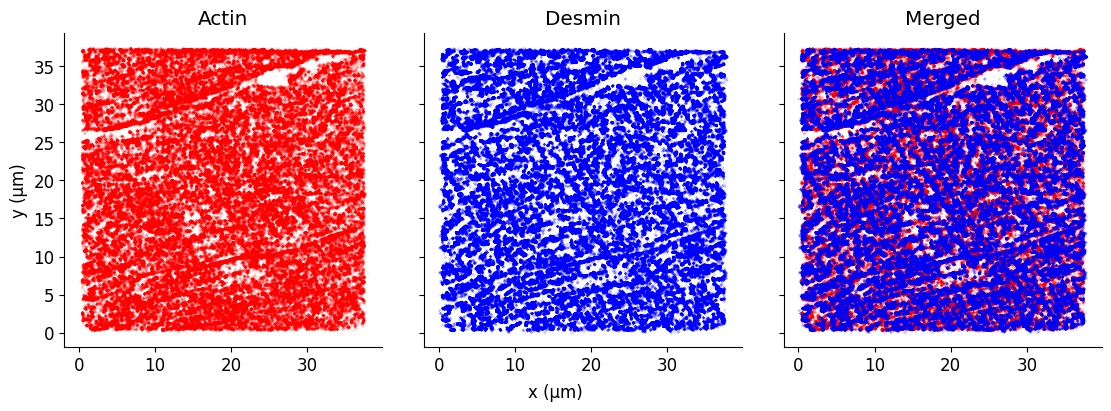

In [6]:
fig, axes = plt.subplots(
    1,
    3,
    figsize=(11, 4),
    sharey=True,
    constrained_layout=True,
    gridspec_kw={"wspace": 0.1},
)
for i in (0, 2):
    axes[i].scatter(
        out[0]["x"],
        out[0]["y"],
        s=0.05,
        c="red",
        # c=np.log10(out[0]["amp"]),
        # cmap=cc.cm.kr_r,
        alpha=0.3,
    )
for i in (1, 2):
    axes[i].scatter(
        out[1]["x"],
        out[1]["y"],
        s=0.05,
        c="blue",
        # c=np.log10(out[1]["amp"]),
        # cmap=cc.cm.kg_r,
        alpha=0.3,
    )

for ax, title in zip(axes, ("Actin", "Desmin", "Merged")):
    ax.axis("equal")

    ax.set_title(title)
axes[0].set_ylabel("y (μm)")
fig.supxlabel("x (μm)", fontsize="medium")

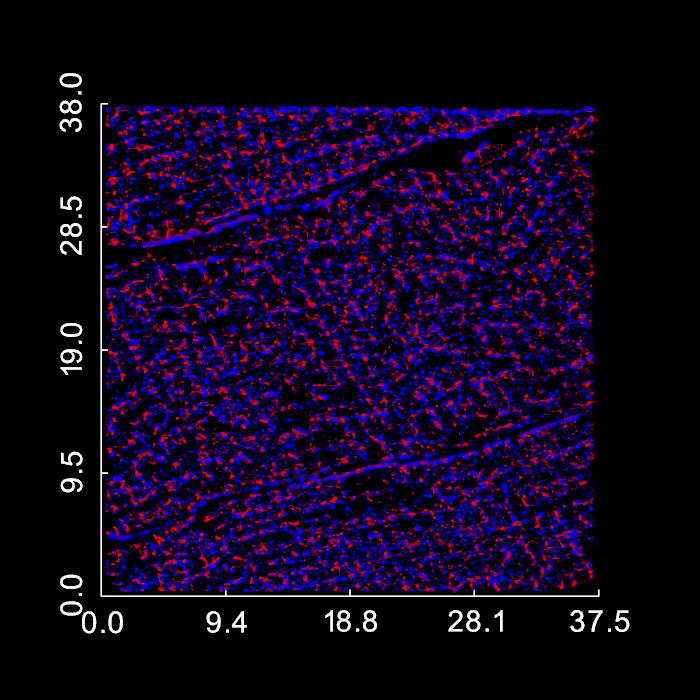

In [ ]:
p = pv.Plotter(notebook=True, window_size=(700, 700))
point_cloud = pv.PolyData(out[1].select(["x", "y", "z"]).to_numpy())
point_cloud = point_cloud.project_points_to_plane(origin=[0, 0, 0], normal=[0, 0, 1])
p.add_mesh(
    point_cloud,
    color="#FF0000",
    style="points_gaussian",
    # emissive=True,
    point_size=0.5,
    opacity=0.1,
)
point_cloud = pv.PolyData(out[0].select(["x", "y", "z"]).to_numpy())
point_cloud = point_cloud.project_points_to_plane(origin=[0, 0, 0], normal=[0, 0, 1])
p.add_mesh(
    point_cloud,
    color="#0000FF",
    style="points_gaussian",
    # emissive=True,
    point_size=1.0,
    opacity=0.1,
)
p.set_background(color="black")
p.enable_parallel_projection()

p.view_xy()
axis = p.show_bounds(
    color="white",
    grid=None,
    axes_ranges=[0, 37.5, 0, 38, 0, 0],
    bold=False,
    font_size=22,
    font_family="arial",
    padding=0.0,
    use_3d_text=False,
    show_zaxis=False,
    xtitle="",
    ytitle="",
)
# axis.x_axis_label_visibility = False
# axis.y_axis_label_visibility = False
# p.camera.tight(padding=0.2)
p.show()

In [15]:
voros = [VoronoiAnalysis(o.select(["x", "y", "z"]).to_numpy()) for o in out]
voro_vols = [v.region_volumes for v in voros]

: 

In [ ]:
def determine_threshold(localizations, n_trials: int = 10, seed: int = 0):
    rng = np.random.default_rng(seed)
    volumes = []
    for _ in tqdm(range(n_trials)):
        voro_rand = VoronoiAnalysis(random_uniform_like(localizations, rng))
        volumes.append(voro_rand.region_volumes)
    return volumes


voro_vol_rands = [determine_threshold(v.points) for v in voros]